# Importing Necessary Libraries

In [1]:
!pip install xclim;
!pip install netCDF4;

     |████████████████████████████████| 381 kB 25.1 MB/s eta 0:00:01
     |████████████████████████████████| 43 kB 87.1 MB/s  eta 0:00:01
     |████████████████████████████████| 290 kB 132.9 MB/s eta 0:00:01
     |████████████████████████████████| 355 kB 141.7 MB/s eta 0:00:01
     |████████████████████████████████| 58 kB 112.4 MB/s eta 0:00:01
     |████████████████████████████████| 194 kB 124.1 MB/s eta 0:00:01
     |████████████████████████████████| 40 kB 99.8 MB/s eta 0:00:01
     |████████████████████████████████| 12.2 MB 129.9 MB/s eta 0:00:01
     |████████████████████████████████| 3.7 MB 120.1 MB/s eta 0:00:01
     |████████████████████████████████| 16.9 MB 116.0 MB/s eta 0:00:01
     |████████████████████████████████| 43.6 MB 130.1 MB/s eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
  Attempting uninstall: pandas
    Found existing installation: pandas 2.0.3
    

In [2]:
import os, sys, glob
from datetime import datetime

import numpy as np
import pandas as pd
import xarray as xr

import s3fs
import netCDF4 as nc
import zarr
from datetime import datetime
import time
import os, sys
import itertools
import numpy as np
import pandas as pd
import xarray as xr
import s3fs
import xclim
import netCDF4 as nc

In [3]:
sys.path.append(r"/opt/app-root/src/hazard_FR/src")
from hazard.sources.nex_gddp_cmip6 import NexGddpCmip6

# Login Details & Connection

In [4]:
from dotenv import load_dotenv,dotenv_values
load_dotenv("/opt/app-root/src/hazard_FR/credentials-dev.env",override=True)
HAZARD_INDICATORS_S3_ACCESS_KEY:str = os.getenv("HAZARD_INDICATORS_S3_ACCESS_KEY")
HAZARD_INDICATORS_S3_SECRET_KEY:str = os.getenv("HAZARD_INDICATORS_S3_SECRET_KEY")
s3_bucket:str = os.getenv("s3_bucket")
s3_group_path=s3_bucket+"/drought/osc/v01"
s3_group_path


'physrisk-hazard-indicators-dev01/drought/osc/v01'

In [5]:
s3 = s3fs.S3FileSystem(anon=False, key=HAZARD_INDICATORS_S3_ACCESS_KEY, secret=HAZARD_INDICATORS_S3_SECRET_KEY)
fs_CIMP6 = s3fs.S3FileSystem(anon=True)
datasource = NexGddpCmip6()

# Model Details

In [6]:
gcm = "MIROC6"     #"ACCESS-CM2"
scenario = "ssp585"

# Variables Setup

In [7]:
years = np.arange(1950, 2101)
variables = ['tas','pr']
lat_chunk_size = 40
lon_chunk_size = 40

# Downloading CIMP6 Data

## Defining functions for downloading data and logging

In [8]:
def download_dataset(variable,year,gcm,scenario,fs=fs_CIMP6, datasource=datasource):
    scenario_ = "historical" if year < 2015 else scenario
    datapath,_ = datasource.path(gcm=gcm, scenario=scenario_, quantity=variable, year=year)
    f = fs.open(datapath, 'rb')
    ds = xr.open_dataset(f).astype('float32').compute()
    return ds

def delete_existing_log(gcm,scenario,s3_group_path=s3_group_path):
    s3_rechunk_log = os.path.join(s3_group_path,'logs',"Rechunking" +"_" + gcm + "_" + scenario + ".csv")
    s3.rm(s3_rechunk_log)
    return

def read_log(gcm,scenario,variable,year,years=years,variables=variables,s3_group_path=s3_group_path):
    s3_rechunk_log = os.path.join(s3_group_path,'logs',"Rechunking" +"_" + gcm + "_" + scenario + ".csv")
    try:
        with s3.open(s3_rechunk_log,'r') as f:
            df_log = pd.read_csv(f).set_index(['Variable','Year']).astype('bool')
    except FileNotFoundError:
        df_log = (
                    pd.DataFrame([years for variable in variables],index=variables)
                    .T
                    .stack()
                    .reset_index()
                    .rename(columns={'level_1':'Variable',0:'Year'})
                    .drop(columns='level_0')
                    .assign(DownloadedFlag=False)
                    .set_index(['Variable','Year'])
                    .sort_index()
                )
    return df_log.loc[variable,year]['DownloadedFlag']

def update_rechunk_log(gcm,scenario,variable,year,flag=True,years=years,variables=variables,s3_group_path=s3_group_path):
    s3_rechunk_log = os.path.join(s3_group_path,'logs',"Rechunking" +"_" + gcm + "_" + scenario + ".csv")
    try:
        with s3.open(s3_rechunk_log,'r') as f:
            df_log = pd.read_csv(f).set_index(['Variable','Year']).astype('bool')
    except FileNotFoundError:
        df_log = (
                    pd.DataFrame([years for variable in variables],index=variables)
                    .T
                    .stack()
                    .reset_index()
                    .rename(columns={'level_1':'Variable',0:'Year'})
                    .drop(columns='level_0')
                    .assign(DownloadedFlag=False)
                    .set_index(['Variable','Year'])
                    .sort_index()
                )
    df_log.loc[variable,year]['DownloadedFlag'] = flag
    with s3.open(s3_rechunk_log,'w') as f:
        df_log.to_csv(f)
    return

## Downloading the CIMP6 data, rechunking it and saving to S3 bucket

In [9]:
download_dataset_flag = True
delete_existing_log_flag = False

if delete_existing_log_flag:
    delete_existing_log(gcm,scenario)

if download_dataset_flag:

    for variable in variables:
        
        zarr_root = os.path.join(s3_group_path,variable + "_" + gcm + "_" + scenario)
        zarr_store = s3fs.S3Map(root=zarr_root,s3=s3,check=False)
        
        for year in years:
            time_s = time.time()
            already_processed_flag = read_log(gcm,scenario,variable,year)
            if already_processed_flag:
                status = "...previously processed"
            else:
                ds = download_dataset(variable,year,gcm,scenario).chunk({'time':365,'lat':lat_chunk_size,'lon':lon_chunk_size})
                if year == 1950:
                    ds.to_zarr(store=zarr_store,mode='w')
                else:
                    ds.to_zarr(store=zarr_store,append_dim='time')
                update_rechunk_log(gcm,scenario,variable,year)
                status = "...completed processing"
            time_e = time.time()
            print(f"variable = {variable}, year = {year} "  + status + "...("+f"{(time_e-time_s):.2f}sec"+")")

KeyboardInterrupt: 

# Calculating SPEI Index

## Setting up parameters for calculation

In [63]:
calib_start = datetime(1985,1,1)
calib_end = datetime(2015,1,1)
calc_start = datetime(1985,1,1)
calc_end = datetime(2100,12,31)
freq = "MS"
window = 12
dist = "gamma"
method = "APP"

lat_min = -60.0
lat_max = 90.0
lon_min = 0.0
lon_max = 360.0
lat_delta = 10.0
lon_delta = 10.0

## Auxilliary functions for calculating and logging

In [64]:
def get_datachunks(lat_min=lat_min,lat_max=lat_max,lon_min=lon_min,lon_max=lon_max,lat_delta=lat_delta,lon_delta=lon_delta):
    lat_bins = np.arange(lat_min,lat_max + 0.1*lat_delta,lat_delta)
    lon_bins = np.arange(lon_min,lon_max + 0.1*lon_delta,lon_delta)
    data_chunks = {"Chunk_" + str(i).zfill(4) : dict(list(d[0].items())+list(d[1].items())) for i,d in enumerate(itertools.product([{'lat_min':x[0],'lat_max':x[1]} for x in zip(lat_bins[:-1],lat_bins[1:])],[{'lon_min':x[0],'lon_max':x[1]} for x in zip(lon_bins[:-1],lon_bins[1:])]))}
    return data_chunks

data_chunks = get_datachunks()

In [65]:
def read_variable_from_s3_store(gcm,scenario,variable,lat_min,lat_max,lon_min,lon_max,s3_group_path=s3_group_path):
    zarr_root = os.path.join(s3_group_path, variable + "_" + gcm + "_" + scenario)
    zarr_store = s3fs.S3Map(root=zarr_root, s3=s3, check=False)
    ds = xr.open_zarr(store=zarr_store).sel(lat=slice(lat_min,lat_max),lon=slice(lon_min,lon_max))
    return ds

def calculate_spei(
                        lat_min,
                        lat_max,
                        lon_min,
                        lon_max,
                        gcm=gcm,
                        scenario=scenario,
                        s3_group_path=s3_group_path,
                        freq=freq,
                        window=window,
                        dist=dist,
                        method=method,
                        calib_start=calib_start,
                        calib_end=calib_end,
                        calc_start=calc_start,
                        calc_end=calc_end,
                        num_workers = 4
                    ):
    time_s0 = time.time()
    ds_tas = read_variable_from_s3_store(gcm,scenario,"tas",lat_min,lat_max,lon_min,lon_max,s3_group_path=s3_group_path).chunk({'time':100000})
    ds_pr = read_variable_from_s3_store(gcm,scenario,"pr",lat_min,lat_max,lon_min,lon_max,s3_group_path=s3_group_path).chunk({'time':100000})
    ds_tas=ds_tas.drop_duplicates(dim=...,keep='last').sortby('time')
    ds_pr=ds_pr.drop_duplicates(dim=...,keep='last').sortby('time')
    ds_pet = xclim.indices.potential_evapotranspiration(tas=ds_tas['tas'],method='MB05').astype('float32').to_dataset(name='pet')
    da_wb=xclim.indices.water_budget(pr=ds_pr['pr'],evspsblpot=ds_pet['pet'])
    with xr.set_options(keep_attrs=True):
        da_wb=da_wb-1.01*da_wb.min()
    # da_wb = da_wb #da_wb.compute() #.chunk(chunks={'time':100000})
    da_wb_calib = da_wb.sel(time=slice(str(calib_start)[:10],str(calib_end)[:10]))
    da_wb_calc = da_wb.sel(time=slice(str(calc_start)[:10],str(calc_end)[:10]))
    ds_spei = (
                    xclim.indices.standardized_precipitation_evapotranspiration_index(
                                                                                            da_wb_calc,
                                                                                            da_wb_calib,
                                                                                            freq=freq,
                                                                                            window=window,
                                                                                            dist=dist,
                                                                                            method=method
                                                                                        )
                    .astype('float32')
                    .to_dataset(name='spei')
                    .compute(scheduler='processes',num_workers=num_workers)
                )
    time_e0 = time.time()
    print("(time taken: "+f"{(time_e0-time_s0):.2f}sec"+")")
    return ds_spei

def delete_existing_calc_log(gcm,scenario,s3_group_path=s3_group_path):
    s3_rechunk_log = os.path.join(s3_group_path,'logs',"Calc" +"_" + gcm + "_" + scenario + ".csv")
    s3.rm(s3_rechunk_log)
    return

def read_calc_log(gcm,scenario,chunk_name,s3_group_path=s3_group_path,data_chunks=data_chunks):
    s3_calc_log = os.path.join(s3_group_path,'logs',"Calc" +"_" + gcm + "_" + scenario + ".csv")
    try:
        with s3.open(s3_calc_log,'r') as f:
            df_log = pd.read_csv(f).astype({'ChunkName':'string'}).set_index(['ChunkName']).astype('bool')
    except FileNotFoundError:
        df_log = (
                    pd.DataFrame([chunk_name for chunk_name in data_chunks],columns=['ChunkName'])
                    .astype('string')
                    .set_index('ChunkName')
                    .assign(DownloadedFlag=False)
                )
    return df_log.loc[chunk_name]['DownloadedFlag']

def update_calc_log(gcm,scenario,chunk_name,flag=True,s3_group_path=s3_group_path,data_chunks=data_chunks):
    s3_calc_log = os.path.join(s3_group_path,'logs',"Calc" +"_" + gcm + "_" + scenario + ".csv")
    try:
        with s3.open(s3_calc_log,'r') as f:
            df_log = pd.read_csv(f).astype({'ChunkName':'string'}).set_index(['ChunkName']).astype('bool')
    except FileNotFoundError:
        df_log = (
                    pd.DataFrame([chunk_name for chunk_name in data_chunks],columns=['ChunkName'])
                    .astype('string')
                    .set_index('ChunkName')
                    .assign(DownloadedFlag=False)
                )
    df_log.loc[chunk_name]['DownloadedFlag']=flag
    with s3.open(s3_calc_log,'w') as f:
        df_log.to_csv(f)
    return

def get_spei_chunk_results(chunk_name,gcm,scenario,s3_group_path=s3_group_path):
    zarr_root = os.path.join(s3_group_path,"SPEI","ChunkedResults",gcm + "_" + scenario + "_" + chunk_name)
    zarr_store = s3fs.S3Map(root=zarr_root, s3=s3, check=False)
    ds = xr.open_zarr(store=zarr_store)
    return ds

def get_spei_full_results(gcm,scenario,s3_group_path=s3_group_path):
    zarr_root = os.path.join(s3_group_path,"SPEI","Aggregated",gcm + "_" + scenario)
    zarr_store = s3fs.S3Map(root=zarr_root,s3=s3,check=False)
    ds_spei = xr.open_zarr(store=zarr_store)
    return ds_spei

## Calculating SPEI index

In [66]:
run_spei_calcs_flag = True
delete_existing_calc_log_flag = False

chunk_names = list(data_chunks.keys())
num_workers = 4

if delete_existing_calc_log_flag:
    delete_existing_calc_log(gcm,scenario)

    
if run_spei_calcs_flag:

    for chunk_name in chunk_names:

        time_s = time.time()

        data_chunk = data_chunks[chunk_name]
        lat_min = data_chunk['lat_min']
        lat_max = data_chunk['lat_max']
        lon_min = data_chunk['lon_min']
        lon_max = data_chunk['lon_max']

        already_calculated_flag = read_calc_log(gcm,scenario,chunk_name)
        if already_calculated_flag:
            status = "... previously calculated"
        else:
            ds_spei = calculate_spei(lat_min,lat_max,lon_min,lon_max)
            zarr_root = os.path.join(s3_group_path,"SPEI","ChunkedResults",gcm + "_" + scenario + "_" + chunk_name)
            zarr_store = s3fs.S3Map(root=zarr_root,s3=s3,check=False)
            ds_spei.to_zarr(store=zarr_store,mode='w')
            update_calc_log(gcm,scenario,chunk_name)
            status = "... completed calculating"
            
        time_e = time.time()
        print(f"Chunk = {chunk_name} "  + status + " ... ("+f"{(time_e-time_s):.2f}sec"+")")

Chunk = Chunk_0000 ... previously calculated ... (0.08sec)
Chunk = Chunk_0001 ... previously calculated ... (0.18sec)
Chunk = Chunk_0002 ... previously calculated ... (0.03sec)
Chunk = Chunk_0003 ... previously calculated ... (0.06sec)
Chunk = Chunk_0004 ... previously calculated ... (0.03sec)
Chunk = Chunk_0005 ... previously calculated ... (0.03sec)
Chunk = Chunk_0006 ... previously calculated ... (0.03sec)
Chunk = Chunk_0007 ... previously calculated ... (0.03sec)
Chunk = Chunk_0008 ... previously calculated ... (0.03sec)
Chunk = Chunk_0009 ... previously calculated ... (0.03sec)
Chunk = Chunk_0010 ... previously calculated ... (0.03sec)
Chunk = Chunk_0011 ... previously calculated ... (0.03sec)
Chunk = Chunk_0012 ... previously calculated ... (0.03sec)
Chunk = Chunk_0013 ... previously calculated ... (0.04sec)
Chunk = Chunk_0014 ... previously calculated ... (0.03sec)
Chunk = Chunk_0015 ... previously calculated ... (0.03sec)
Chunk = Chunk_0016 ... previously calculated ... (0.03se

## Aggregating SPEI index calculations

In [67]:
calculate_agg_spei_data_flag = False
write_agg_spei_data_flag = False

lat_min = -60.0
lat_max = 90.0
lon_min = 0.0
lon_max = 360.0
lat_delta = 10.0
lon_delta = 10.0

if calculate_agg_spei_data_flag:

    ds_1_ = get_spei_chunk_results("Chunk_0000",gcm,scenario)
    ds_2_ = read_variable_from_s3_store(gcm,scenario,"pr",lat_min,lat_max,lon_min,lon_max)
    times_all = ds_1_['time'].values
    lats_all = ds_2_['lat'].values
    lons_all = ds_2_['lon'].values
    spei_data = np.nan*np.zeros([len(times_all), len(lats_all), len(lons_all)])

    for chunk_name in chunk_names:
        already_calculated_flag = read_calc_log(gcm,scenario,chunk_name)
        if already_calculated_flag:
            ds_chunk = get_spei_chunk_results(chunk_name,gcm,scenario).compute()
            spei_data_chunk = ds_chunk['spei'].values
            lats_chunk = ds_chunk['lat'].values
            lons_chunk = ds_chunk['lon'].values
            lats_ids = [x[0] for x in enumerate(lats_all) if x[1] in lats_chunk]
            lons_ids = [x[0] for x in enumerate(lons_all) if x[1] in lons_chunk]
            spei_data[:,lats_ids[0]:lats_ids[-1]+1,lons_ids[0]:lons_ids[-1]+1] = spei_data_chunk
        print(chunk_name,end='; ')

    if write_agg_spei_data_flag:
        print("\n\nAggregating and Saving outputs")
        ds_spei_all = xr.DataArray(spei_data, coords={'time': times_all, 'lat': lats_all,'lon': lons_all,}, dims=["time","lat", "lon"]).chunk(chunks={'lat':40,'lon':40,'time':100000}).to_dataset(name='spei')
        zarr_root = os.path.join(s3_group_path,"SPEI","Aggregated",gcm + "_" + scenario)
        zarr_store = s3fs.S3Map(root=zarr_root,s3=s3,check=False)
        ds_spei_all.to_zarr(store=zarr_store,mode='w')
        print("Completed!")

## Testing calculation results

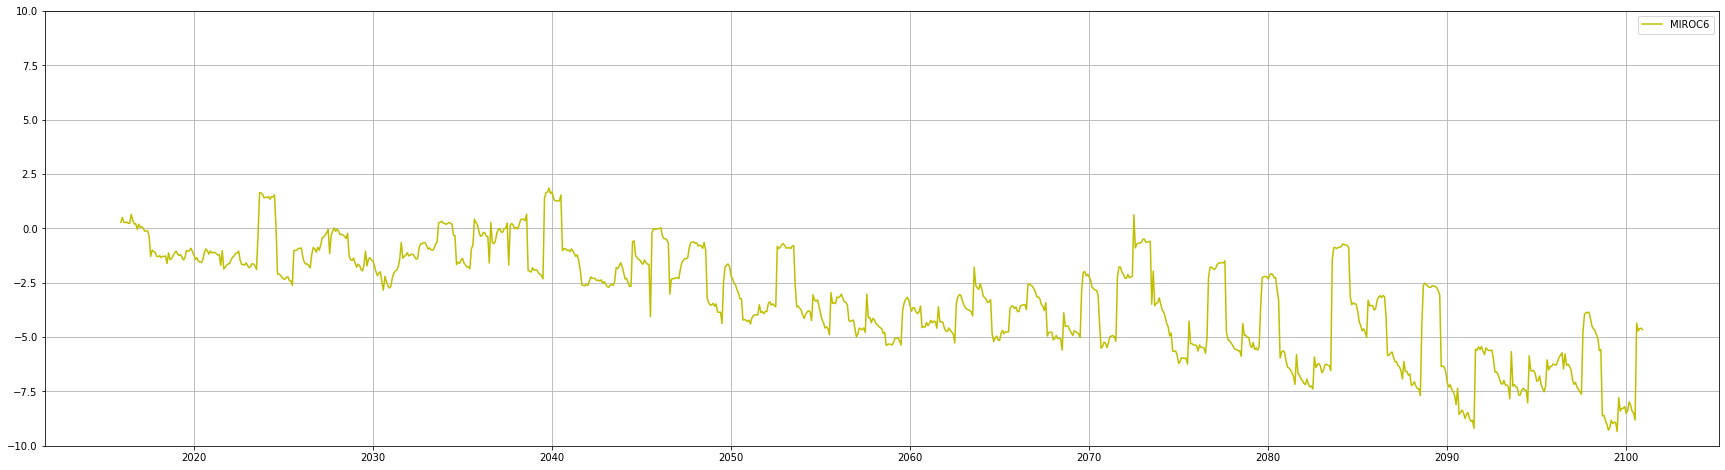

In [68]:
#"CMCC-ESM2"
#"ACCESS-CM2"
# NorESM2-MM
#MPI-ESM1-2-LR
ds_spei_1 = get_spei_full_results("CMCC-ESM2",scenario)
ds_spei_2 = get_spei_full_results("ACCESS-CM2",scenario)
ds_spei_3 = get_spei_full_results("NorESM2-MM",scenario)
ds_spei_4 = get_spei_full_results("MPI-ESM1-2-LR",scenario)
ds_spei_5 = get_spei_full_results("MIROC6",scenario)

ds_1_ = ds_spei_1.sel(lat=20,lon=0,method='nearest').compute()
ds_2_ = ds_spei_2.sel(lat=20,lon=0,method='nearest').compute()
ds_3_ = ds_spei_3.sel(lat=20,lon=0,method='nearest').compute()
ds_4_ = ds_spei_4.sel(lat=20,lon=0,method='nearest').compute()
ds_5_ = ds_spei_5.sel(lat=20,lon=0,method='nearest').compute()

time_1 = ds_1_['time'].values
time_2 = ds_2_['time'].values
time_3 = ds_3_['time'].values
time_4 = ds_4_['time'].values
time_5 = ds_5_['time'].values

time_1 = pd.Series([str(t)[:10] for t in time_1]).astype('datetime64').values
time_2 = pd.Series([str(t)[:10] for t in time_2]).astype('datetime64').values
time_3 = pd.Series([str(t)[:10] for t in time_3]).astype('datetime64').values
time_4 = pd.Series([str(t)[:10] for t in time_4]).astype('datetime64').values
time_5 = pd.Series([str(t)[:10] for t in time_5]).astype('datetime64').values

spei_1 = ds_1_['spei'].values
spei_2 = ds_2_['spei'].values
spei_3 = ds_3_['spei'].values
spei_4 = ds_4_['spei'].values
spei_5 = ds_5_['spei'].values



import matplotlib.pyplot as plt
fig,ax = plt.subplots(figsize=[30,8])
#ax.plot(time_1,spei_1,color='b',label="CMCC-ESM2");
#ax.plot(time_2,spei_2,color='r',label="ACCESS-CM2");
#ax.plot(time_3,spei_3,color='c',label="NorESM2-MM");
#ax.plot(time_4,spei_4,color='m',label="MPI-ESM1-2-LR");
ax.plot(time_5,spei_5,color='y',label="MIROC6");
plt.legend(loc="upper right")
ax.set_ylim([-10,10]);
ax.grid();



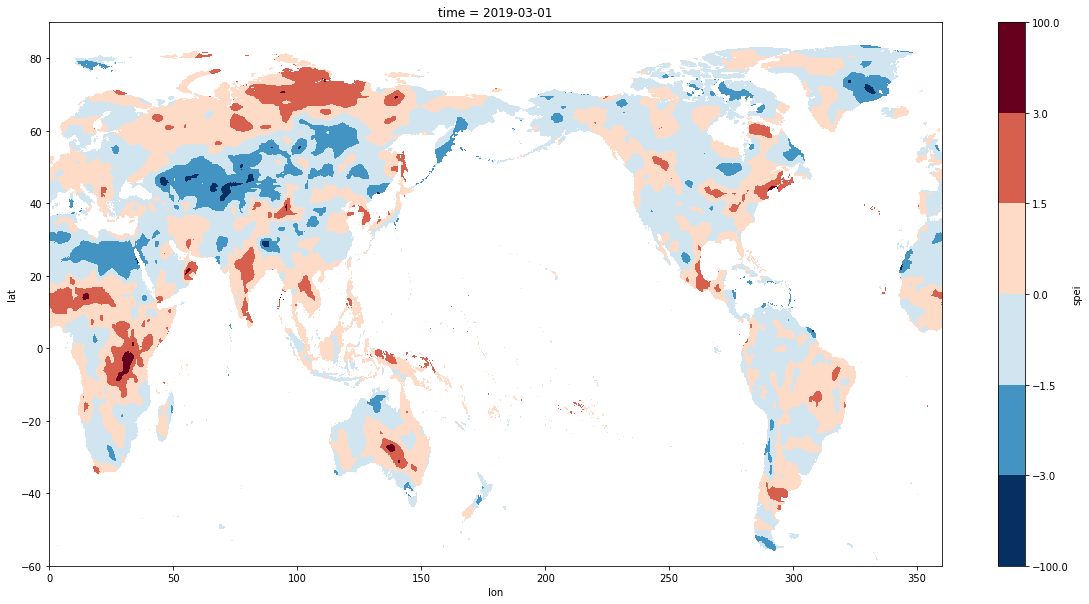

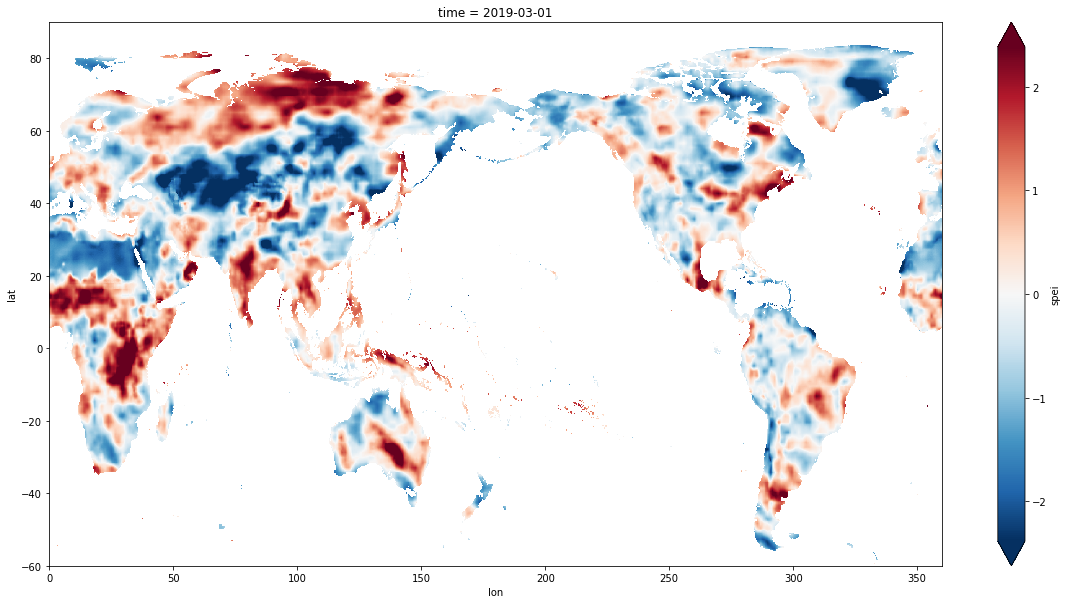

In [69]:
spei = ds_spei_5.isel(time=50).spei
spei.plot(figsize=[20,10],levels=[-100,-3,-1.5,0,1.5,3,100])
spei.plot(robust=True,figsize=[20,10])

## Calculating SPEI indictor year 2005,2030,2040,2050,2080

### Calculating average number of months where 12 - month SPEI index is below thresholds [0,-1,-1.5,-2,-2.5,-3.6] for 20 years period

In [70]:
def calculate_annual_average_spei(gcm, scenario, spei_thr, year, period_years, write_spei_indicator_flag):
    period=[datetime(year-period_years//2,1,1),datetime(year+period_years//2-1,12,31)]
    print(gcm+" "+scenario+" "+str(year)+" period:   "+str(period[0])+"---"+str(period[1])+"\n")
    ds_spei = get_spei_full_results(gcm, scenario)
    lats_all = ds_spei['lat'].values
    lons_all = ds_spei['lon'].values
    spei_annual = np.nan*np.zeros([len(spei_thr), len(lats_all), len(lons_all)])
    for i in range(len(spei_thr)):
        spei_temp = ds_spei.sel(time=slice(period[0], period[1]))
        lats_temp = spei_temp['lat'].values
        lons_temp = spei_temp['lon'].values
        spei_temp = spei_temp.compute()
        spei_temp = spei_temp['spei']
        spei_ext=xr.where((spei_temp <= spei_thr[i]),1,0)
        spei_ext_sum=spei_ext.mean("time")
        lats_ids = [x[0] for x in enumerate(lats_all) if x[1] in lats_temp]
        lons_ids = [x[0] for x in enumerate(lons_all) if x[1] in lons_temp]
        spei_annual[i, lats_ids[0]:lats_ids[-1]+1, lons_ids[0]:lons_ids[-1]+1] = spei_ext_sum
        spei_annual_all = xr.DataArray(spei_annual, coords={'spei_idx': spei_thr, 'lat': lats_all,'lon': lons_all,}, dims=["spei_idx","lat", "lon"])
    if write_spei_indicator_flag:
        print("\nAggregating and Saving SPEI indicator")
        zarr_root = os.path.join(s3_group_path,"SPEI","indicator",gcm + "_" + scenario+ "_" +year)
        zarr_store = s3fs.S3Map(root=zarr_root,s3=s3,check=False)
        #spei_annual_all.to_zarr(store=zarr_store,mode='w')
        print("SPEI Indicator calculation completed!")
    return spei_annual_all

In [71]:
spei_threshold=[0,-1,-1.5,-2,-2.5,-3,-3.6]
period_years=20
spei_annual_average_1 = calculate_annual_average_spei(gcm,scenario,spei_threshold, year=2025, period_years=period_years,write_spei_indicator_flag=False)
spei_annual_average_2 = calculate_annual_average_spei(gcm,scenario,spei_threshold, year=2030, period_years=period_years,write_spei_indicator_flag=False)
spei_annual_average_3 = calculate_annual_average_spei(gcm,scenario,spei_threshold, year=2040, period_years=period_years,write_spei_indicator_flag=False)
spei_annual_average_4 = calculate_annual_average_spei(gcm,scenario,spei_threshold, year=2050, period_years=period_years,write_spei_indicator_flag=False)
spei_annual_average_5 = calculate_annual_average_spei(gcm,scenario,spei_threshold, year=2080, period_years=period_years,write_spei_indicator_flag=False)

MIROC6 ssp585 2025 period:   2015-01-01 00:00:00---2035-12-31 00:00:00

MIROC6 ssp585 2030 period:   2020-01-01 00:00:00---2040-12-31 00:00:00

MIROC6 ssp585 2040 period:   2030-01-01 00:00:00---2050-12-31 00:00:00

MIROC6 ssp585 2050 period:   2040-01-01 00:00:00---2060-12-31 00:00:00

MIROC6 ssp585 2080 period:   2070-01-01 00:00:00---2090-12-31 00:00:00



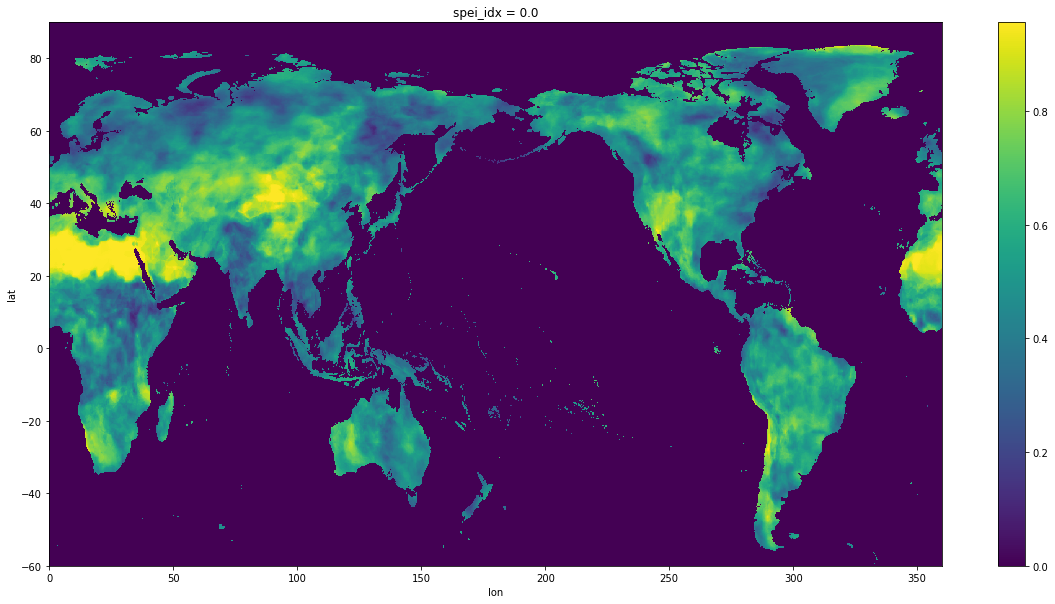

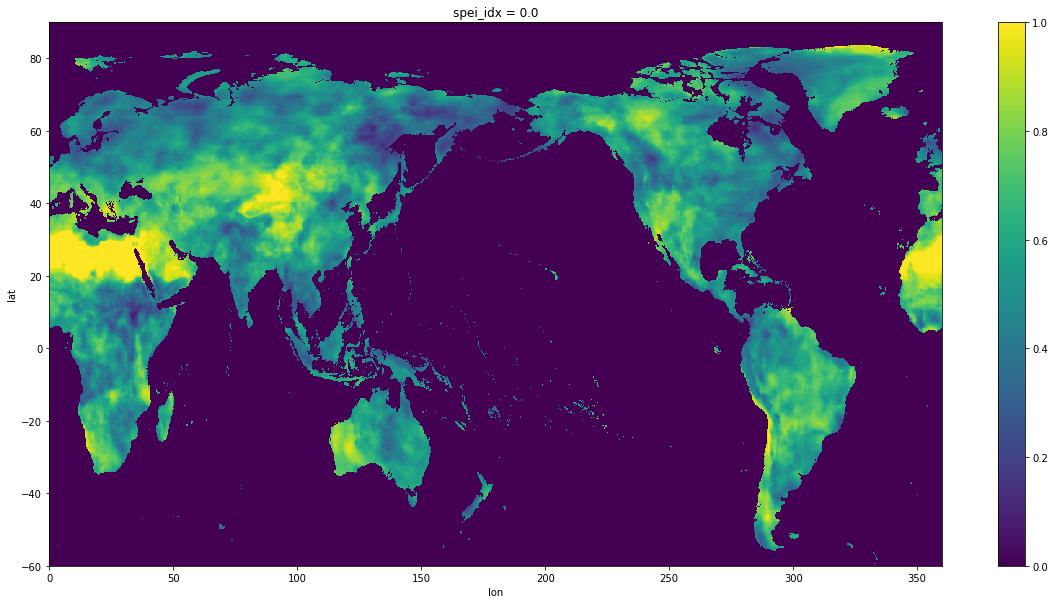

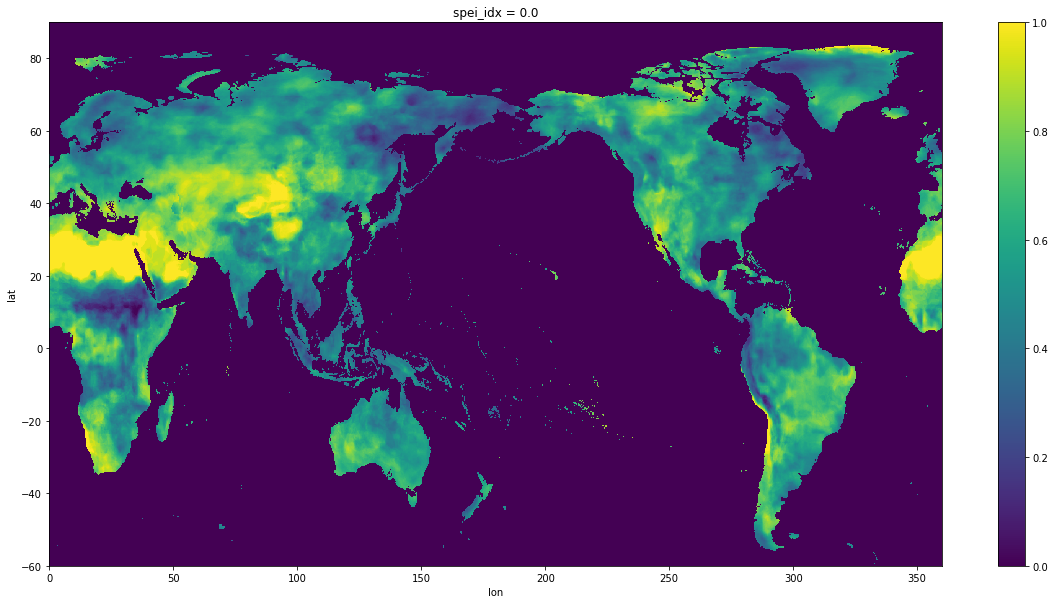

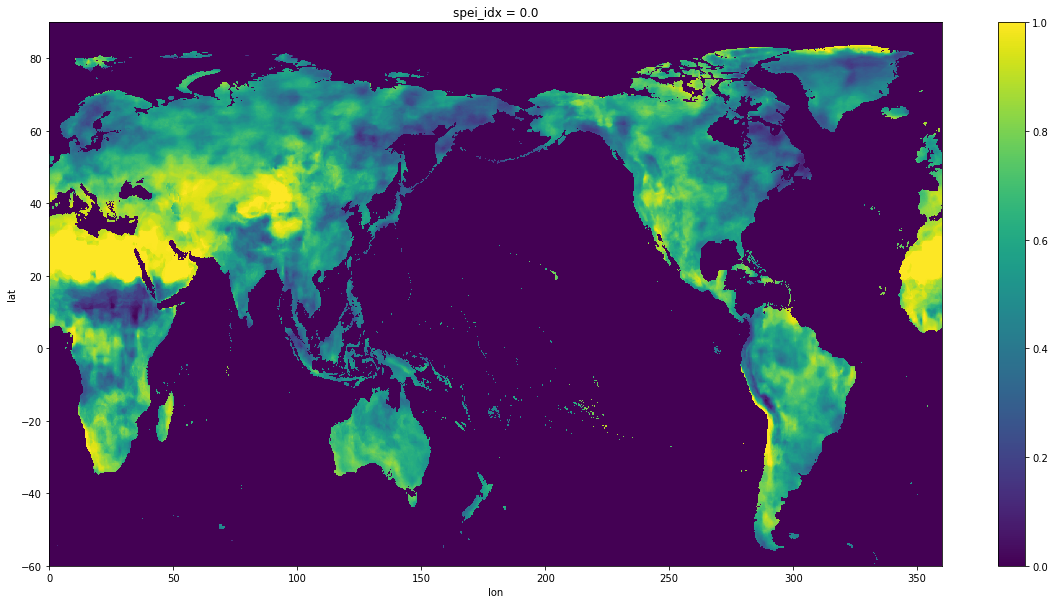

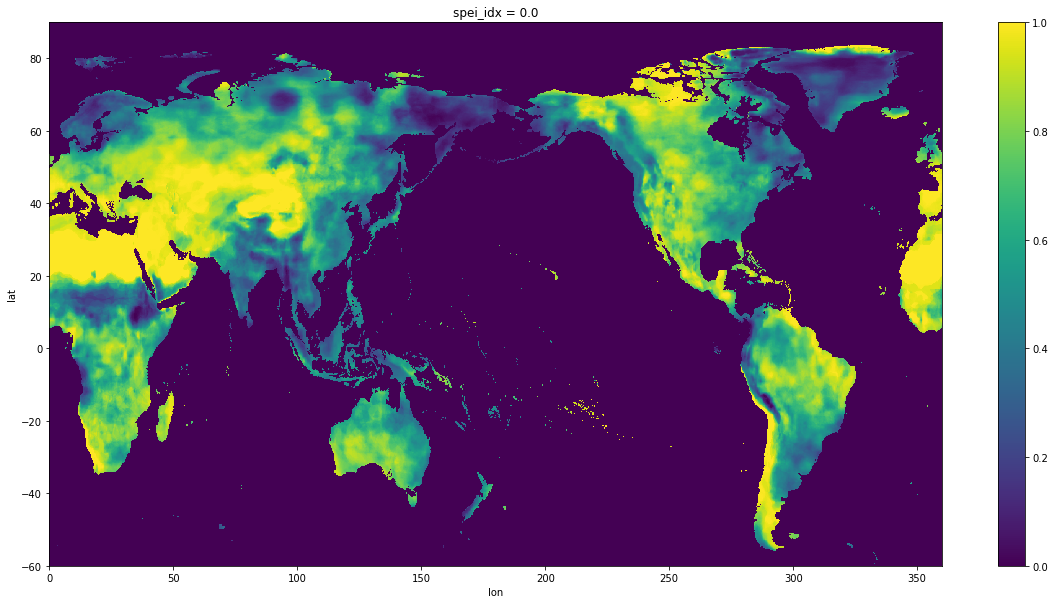

In [72]:
spei_annual_average_1.sel(spei_idx=-0).plot(figsize=[20,10])
spei_annual_average_2.sel(spei_idx=-0).plot(figsize=[20,10])
spei_annual_average_3.sel(spei_idx=-0).plot(figsize=[20,10])
spei_annual_average_4.sel(spei_idx=-0).plot(figsize=[20,10])
spei_annual_average_5.sel(spei_idx=-0).plot(figsize=[20,10])

In [29]:
from hazard.sources.osc_zarr import OscZarr

In [30]:
print("\n\nAggregating and Saving SPEI indicator")
year=2025
zarr_root = os.path.join("drought/osc/v1","months_spei12m_below_set_"+gcm+"_"+scenario+"_"+str(year))
zarr_store = s3fs.S3Map(root=zarr_root,s3=s3,check=False)
target = OscZarr(bucket="-dev-01",prefix="hazard",store=zarr_store)
#target.write(zarr_root,spei_annual_average)
zarr_root



Aggregating and Saving SPEI indicator


PermissionError: Forbidden

In [32]:
zarr_root
#da = target.read('chronic_heat/osc/v2/days_tas_above_15c_NorESM2-MM_ssp585_2030')

'drought/osc/v1/months_spei12m_below_set_MIROC6_ssp585_2025'

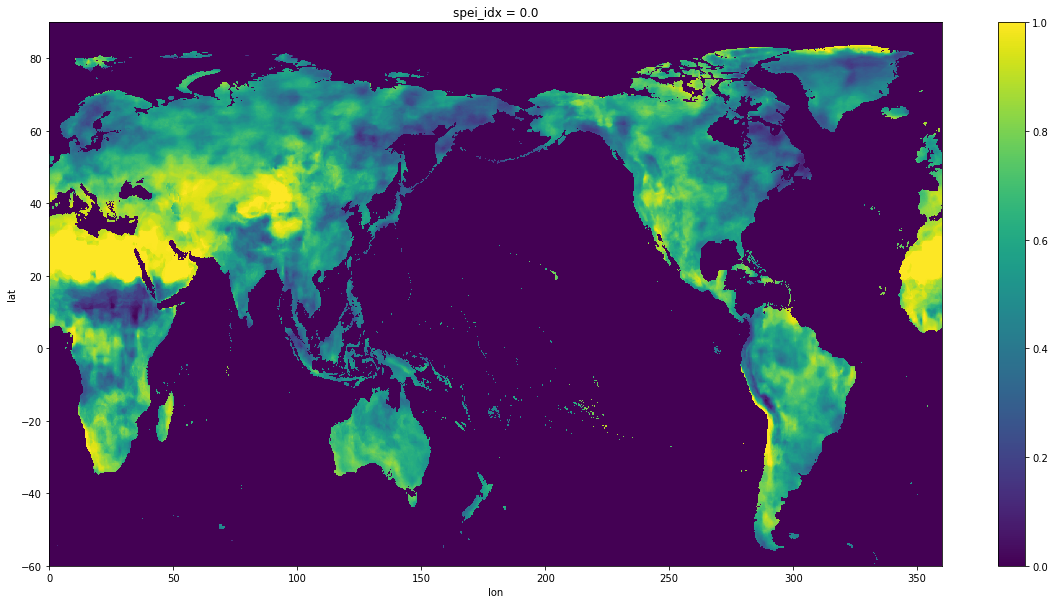

In [99]:
spei_annual_average.sel(spei_idx=0).plot(figsize=[20,10])